In [117]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [118]:
#Carico il dataset

data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

data = data.sample(frac=1, random_state=8324).reset_index(drop=True) #shuffle
print("Shape del dataset : ", data.shape)

Shape del dataset :  (13451, 22)


Total :  13451
Normal :  7500
Malicious :  5951


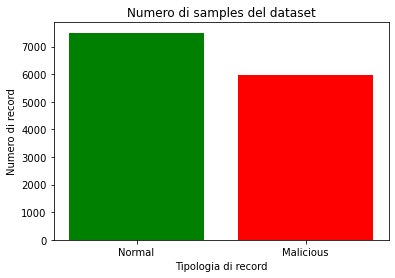

In [119]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [120]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

In [121]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')
data.flag.replace(flag_list, range(len(flag_list)), inplace=True)

Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [122]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = data['result'].copy().values.reshape((data.shape[0], 1))
df_label = pd.DataFrame(label)
data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        data[i] = data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        data[i] = data[i].map(lambda x: std if x > std else x)
sc.fit(data[['duration', 'src_bytes', 'dst_bytes']].values)
data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Converting count data (index 22, 31, 32) to machine readable...')
sc.fit(data[['count']].values.astype(np.float32))
data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Converting type data (index 1, 2, 3) to machine readable...')
enc.fit(data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(data[['protocol_type','service','flag']].values).toarray()

print('Dropping and attaching one-hot encoding data...')
data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print('Final shape of data:', data_final.shape)

Converting count data (index 22, 31, 32) to machine readable...
Converting type data (index 1, 2, 3) to machine readable...
Dropping and attaching one-hot encoding data...
Final shape of data: (13451, 95)


In [123]:

normal_data = data_final[data_final[94] == "normal"] #prendo solo i valori "normali" 

#voglio che sia il train che la validation siano effettuati su record normali ma che siano tra loro differenti

data_train, data_val, data_test = np.split(normal_data, [int(.6*len(normal_data)), int(.8*len(normal_data))])
        
x_train = data_train.drop([94],axis=1) #rimuove la colonna result dal dataframe
x_val = data_val.drop([94], axis=1) #rimuove il label

print("Shape dataframe per il train : ", x_train.shape)
print("Shape dataframe per la validation : ", x_val.shape)

Shape dataframe per il train :  (4500, 94)
Shape dataframe per la validation :  (1500, 94)


In [124]:
x_train_arr = np.asarray(x_train).astype(np.float32)
x_train_arr = x_train_arr.reshape(x_train_arr.shape[0],x_train_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

x_val_arr = np.asarray(x_val).astype(np.float32)
x_val_arr = x_val_arr.reshape(x_val_arr.shape[0],x_val_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM


print("Shape numpy array per il train : ", x_train_arr.shape)
print("Shape numpy array per la validation : ", x_val_arr.shape)

Shape numpy array per il train :  (4500, 94, 1)
Shape numpy array per la validation :  (1500, 94, 1)


In [125]:
model = keras.Sequential(
    [
       layers.Input(shape=(x_train_arr.shape[1],x_train_arr.shape[2])),
       layers.LSTM(8, activation='relu', return_sequences=True),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(64),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(x_train_arr.shape[1], activation='sigmoid'),
       layers.LSTM(8, activation='relu', return_sequences=True),
       layers.TimeDistributed(layers.Dense(1)),
    ]
)

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile( optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 94, 8)             320       
_________________________________________________________________
dense_85 (Dense)             (None, 94, 512)           4608      
_________________________________________________________________
dropout_70 (Dropout)         (None, 94, 512)           0         
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 94, 512)           0         
_________________________________________________________________
dense_86 (Dense)             (None, 94, 256)           131328    
_________________________________________________________________
dropout_71 (Dropout)         (None, 94, 256)           0         
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 94, 256)         

In [126]:
history = model.fit(
    x_train_arr,
    x_train_arr,
    epochs=100,
    batch_size=5,
    validation_data=(x_val_arr, x_val_arr),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
)

Epoch 1/100
900/900 [==============================] - 31s 34ms/step - loss: 0.0964 - val_loss: 0.1427
Epoch 2/100
900/900 [==============================] - 34s 38ms/step - loss: 0.0896 - val_loss: 0.1420
Epoch 3/100
900/900 [==============================] - 34s 38ms/step - loss: 0.0865 - val_loss: 0.1260
Epoch 4/100
900/900 [==============================] - 34s 38ms/step - loss: 0.0697 - val_loss: 0.1219
Epoch 5/100
900/900 [==============================] - 34s 38ms/step - loss: 0.0655 - val_loss: 0.1144
Epoch 6/100
900/900 [==============================] - 34s 38ms/step - loss: 0.0660 - val_loss: 0.0955
Epoch 7/100
900/900 [==============================] - 34s 38ms/step - loss: 0.0571 - val_loss: 0.0999
Epoch 8/100
900/900 [==============================] - 35s 38ms/step - loss: 0.0548 - val_loss: 0.0937
Epoch 9/100
900/900 [==============================] - 34s 38ms/step - loss: 0.0587 - val_loss: 0.0891
Epoch 10/100
900/900 [==============================] - 34s 38ms/step - l

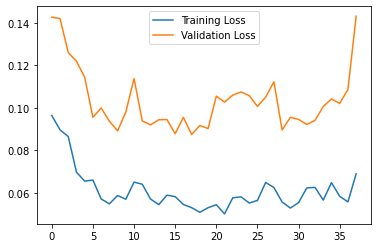

In [127]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

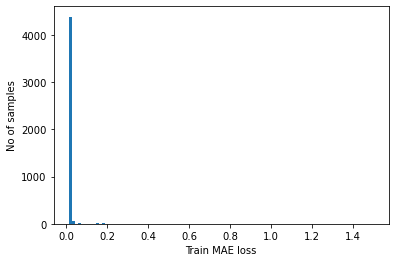

Reconstruction error threshold:  0.015996054


In [128]:
x_train_pred = model.predict(x_train_arr)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_arr), axis=1)
train_mae_loss = train_mae_loss.ravel() #converte l'array numpy in 1d
train_mae_loss = np.sort(train_mae_loss) #quicksort


train_mae_loss_len = len(train_mae_loss)
n_index = int(0.75*train_mae_loss_len)
plt.hist(train_mae_loss, bins=100)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
train_mae_loss_split = train_mae_loss[:n_index]
threshold = np.max(train_mae_loss_split)
print("Reconstruction error threshold: ", threshold)

In [129]:
#data_test
#il dataset per il test sarà formato dai 1500 sample normali prelevati precedentemente a cui aggiungerò dei sample anomali
#in particolare prelevo il 20% dei sample anomali e li concateno ai 1500 normali precedentemente ottenuti

anomaly_data = data_final[data_final[94] != "normal"] #prendo solo i valori "anomali"

percentage = 20
anomaly_test_data = anomaly_data.head(int(len(anomaly_data)*(percentage/100)))

frames = [data_test, anomaly_test_data]
final_test_data = pd.concat(frames)

print("Shape del dataset per il test: ", final_test_data.shape)

Shape del dataset per il test:  (2690, 95)


Total :  2690
Normal :  1500
Malicious :  1190


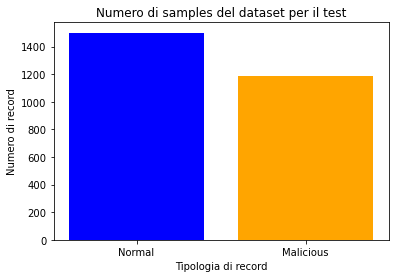

x_test shape : (2690, 94)


In [130]:
total_flows_count_test = final_test_data[94].count()
normal_flows_count_test = len(final_test_data[final_test_data[94] == "normal"])
anomaly_flows_count_test = len(final_test_data[final_test_data[94] != "normal"])

print("Total : ",total_flows_count_test)
print("Normal : ",normal_flows_count_test)
print("Malicious : ",anomaly_flows_count_test)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count_test, anomaly_flows_count_test] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['blue', 'orange']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset per il test') 
  
plt.show() 

data_test_with_label = final_test_data.copy()
x_test = final_test_data.drop([94],axis=1) #rimuove la colonna dei result dal dataframe

print("x_test shape :", x_test.shape)

In [133]:
x_test_arr = np.asarray(x_test).astype(np.float32)
x_test_arr = x_test_arr.reshape(x_test_arr.shape[0],x_test_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

print("Shape numpy array per il test : ", x_test_arr.shape)

Shape numpy array per il test :  (2690, 94, 1)


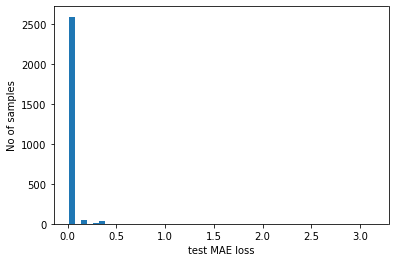

Number di sample anomali rilevati:  1567
Numero di sample anomali rivelati erroneamente:  0
Numero di sample anomali rilevati correttamente:  1567
Numero di sample anomali non rivelati:  0


Indices of anomaly samples:  (array([   2,   11,   12, ..., 2687, 2688, 2689], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [134]:
arr_test_pred = model.predict(x_test_arr)
test_mae_loss = np.mean(np.abs(arr_test_pred - x_test_arr), axis=1)
                                       
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
count = 0
false_negative = 0
false_positive = 0


for i in anomalies:
    if ( i == True ):
        if ( data_test_with_label.iloc[count][94] == "normal"):
            false_negative = false_negative + 1
    if (i == False):
        if( data_test_with_label.iloc[count][94] != "normal"):
            false_positive = false_positive + 1
    count = count + 1
        
print("Number di sample anomali rilevati: ", np.sum(anomalies))
print("Numero di sample anomali rivelati erroneamente: ", false_negative)
print("Numero di sample anomali rilevati correttamente: ", np.sum(anomalies)-false_negative)
print("Numero di sample anomali non rivelati: ", false_positive)
print("")
print("")
print("Indices of anomaly samples: ", np.where(anomalies))                                       